# Horizontal surface velocities
ADCP measurements are aggregated at the CTD location and averaged over the period of the CTD cast. Then, the ADCP velocities are averaged over the mixed layer depth and the according standard deviation of the velocity over that depth is determined.

In [1]:
from IPython.display import HTML

%run ../../_setup.py

from netCDF4 import Dataset, num2date
from xarray import open_dataset

import math
import numpy as np
from scipy.interpolate import griddata

from datetime import datetime
from pandas import to_datetime
import pyproj

from OceanPy.animations import play2D

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors

from matplotlib.patches import Rectangle, FancyArrow
from matplotlib.lines import Line2D
from matplotlib.legend_handler import HandlerBase, HandlerLine2D, HandlerPatch

import cmocean as cmo
import string

In [2]:
def Rsquared(var_x, var_y, mask=None):
    
    mask_x, mask_y = np.ma.masked_invalid(var_x).mask, np.ma.masked_invalid(var_y).mask
    mask = np.zeros(mask_x.shape, dtype=bool) if mask is None else mask
    mask = mask | mask_x | mask_y

    coef = np.polyfit(var_x[~mask], var_y[~mask], 1)
    f = np.poly1d(coef)
    
    # coefficient of determination
    SSres = np.sum((var_y[~mask] - f(var_x)[~mask])**2)
    SStot = np.sum((var_y[~mask] - np.nanmean(var_y[~mask]))**2)
    
    R2 = 1 - (SSres/SStot)
    
    return R2, f

def display_animation(anim):
    plt.close(anim._fig)
    return HTML(anim.to_html5_video())

def dh_cts(ct, bounds, ax=None, start=0, end=-1, step=1):
    for ib, b in enumerate(bounds):
        if b in bounds[start:end:step]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=3)
    ax.clabel(ct, bounds[start:end:step], inline=1, fontsize=10)
    return ax

class HandlerColormap(HandlerBase):
    def __init__(self, cmap, num_stripes=8, **kw):
        HandlerBase.__init__(self, **kw)
        self.cmap = cmap
        self.num_stripes = num_stripes
    def create_artists(self, legend, orig_handle, 
                       xdescent, ydescent, width, height, fontsize, trans):
        stripes = []
        for i in range(self.num_stripes):
            s = Rectangle([xdescent + i * width / self.num_stripes, 0.5*height], 
                          width / self.num_stripes, 0.35*height, 
                          fc=self.cmap((2 * i + 1) / (2 * self.num_stripes)), 
                          transform=trans)
            stripes.append(s)
        return stripes

In [3]:
savefig = False

fs_small=12
fs_large = 14
plt.rc('xtick',labelsize=fs_small)
plt.rc('ytick',labelsize=fs_small)
plt.rc('text', usetex=True)

## ADCP velocities (at CTD locations) from surface to mixed layer depth
The mixed layer depth is determined according to Holte and Talley, 2009, by using a temperature criteria. The standard deviation of the ADCP velocities in the mixed layer depth is determined by calculating the velocity magnitude, then average it over the depth to calculate the standard deviation. This is than plotted as circles around the averaged velocity vectors.

In [4]:
# load ctd data
input_file_ctd = os.path.join(datadir, 'ss9802', 'processed', 'ctd', 'ss9802_ctd_gsw.nc')
ctd = Dataset(input_file_ctd)

# load adcp data
input_file_adcp = os.path.join(datadir, 'ss9802', 'processed', 'adcp', 'ss9802_adcp_ctd.nc')
adcp = Dataset(input_file_adcp)

input_file_adcp_mld = os.path.join(datadir, 'ss9802', 'processed', 'adcp', 'ss9802_adcp_ctd_mld.nc')
adcp_mld = open_dataset(input_file_adcp_mld, group='MLD')

# load ssh/ altimetry data
input_file = os.path.join(datadir, 'external', 'ssh', 'rep', 'rep_allsat_phy_l4_135_-60_160_-45_1998.nc')
ssh = open_dataset(input_file)

# load gradient wind data
input_file_gw = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_135_-53_149_-47_199803_gw.nc')
gw = open_dataset(input_file_gw, group='GW')
input_file_gw_ctd = os.path.join(datadir, 'external', 'ssh', 'processed', 'rep_allsat_phy_l4_ss9802_gw_ctd.nc')
gw_ctd = open_dataset(input_file_gw_ctd, group='CTD')

In [5]:
# find indices for pressure levels in CTD prodiles
pressure_levels = {}
for ip, p in enumerate(ctd['p'][:]):
    pressure_levels[p] = ip

# define reference and interest level 
# p_ref = 1494
p_int = 2

# get dynamic height contours
D = np.array([ctd['deltaD'][profile, pressure_levels[p_int]] / 
              ctd['g'][profile, pressure_levels[p_int]]
              for profile in range(len(ctd.dimensions['profile']))])

# find finite values
mask = np.isfinite(D)
mask[0:2] = False

# interpolate linearly dynamic height contours on grid
lon_ctd, lat_ctd = ctd['lon'][:, 0], ctd['lat'][:, 0]
nx, ny = 20, 20
xi = np.linspace(lon_ctd[mask].min(), lon_ctd[mask].max(), nx)
yi = np.linspace(lat_ctd[mask].min(), lat_ctd[mask].max(), ny)
xxD, yyD = np.meshgrid(xi, yi)
Dgrd = griddata((lon_ctd[mask], lat_ctd[mask]), D[mask], (xxD, yyD), method='linear')

nst = ctd.dimensions['profile'].size


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:13: UserWarning: Warning: converting a masked element to nan.
  del sys.path[0]


In [6]:
# find reference depth
ref_dep = 20
iref = pressure_levels[ref_dep]

# calculate mean of velocities from surface to pressure level
idx_mld = adcp_mld['idxp_mld']

umldmean = np.ma.masked_invalid([adcp_mld['u_ctd'][ist, slice(iref, int(idx_mld[ist]))].mean() for ist in range(nst)])
vmldmean = np.ma.masked_invalid([adcp_mld['v_ctd'][ist, slice(iref, int(idx_mld[ist]))].mean() for ist in range(nst)])

# calculate magnitude of vectors and calculate standard deviation
Vadcp_mld = np.ma.masked_invalid(np.sqrt(adcp_mld['u_ctd']**2 + adcp_mld['v_ctd']**2))

Vmldavg = np.ma.masked_invalid([Vadcp_mld[ist, slice(iref, int(idx_mld[ist]))].mean() for ist in range(nst)])
Vmldstd = np.ma.masked_invalid([Vadcp_mld[ist, slice(iref, int(idx_mld[ist]))].std()
                       if not all(Vadcp_mld[ist, slice(iref, int(idx_mld[ist]))].mask) else np.nan for ist in range(nst)])


/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/xarray/core/nanops.py:142: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis=axis, dtype=dtype)
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/numpy/ma/core.py:2369: UserWarning: Warning: converting a masked element to nan.
  a = np.array(a, copy=copy, subok=True)


In order to see if the ADCP velocity vectors follow the geostrophic current, the linearly interpolated dynamic height contours between 1500-1000 dbar are plotted in the background.

/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in greater
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:26: RuntimeWarning: invalid value encountered in less_equal
/home/janjaapmeijer/miniconda3/envs/ocean36/lib/python3.6/site-packages/ipykernel_launcher.py:23: RuntimeWarning: invalid value encountered in greater


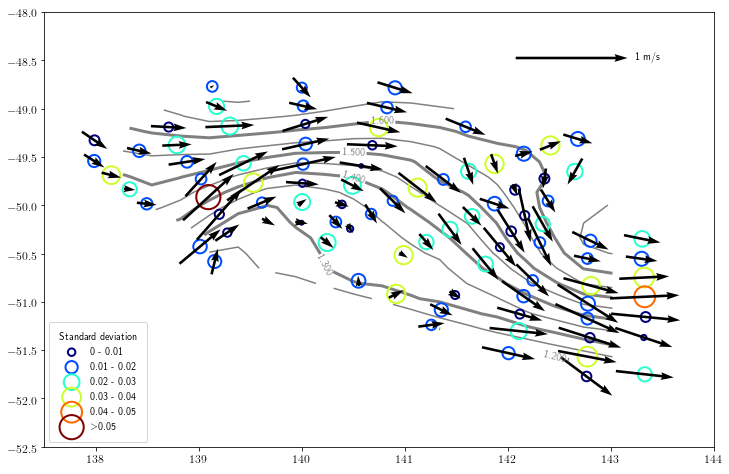

In [7]:
fig, ax = plt.subplots(figsize=(12, 8))

# plot dynamic height contours
step = 0.05
xmin, xmax = 1.2, 1.7
nsteps = int((xmax - xmin) / step) + 1
bounds = np.linspace(xmin, xmax, nsteps)

ct = ax.contour(xxD, yyD, Dgrd, bounds, colors='gray', zorder=-1)
dh_cts(ct, bounds, step=2, ax=ax)

# plot quiver plot
Q = ax.quiver(adcp['lon_ctd'][2:], adcp['lat_ctd'][2:], umldmean[2:], vmldmean[2:], 
              pivot='mid', units='inches', width=0.003*12, zorder=2)
qk = plt.quiverkey(Q, 0.8, 0.8, 1, '1 m/s', labelpos='E', 
                   coordinates='figure', fontproperties={'size': 'medium'})

# plot standard deviation scatter
std_bins = [0, 0.01, 0.02, 0.03, 0.04, 0.05]
colors = cm.jet(np.linspace(0, 1, len(std_bins)))
for i in range(len(std_bins)):
    if i == len(std_bins)-1:
        criteria = (Vmldstd[2:] > std_bins[i])
        label = r'\textgreater %s' % (std_bins[i])
    else:
        criteria = (Vmldstd[2:] > std_bins[i]) & (Vmldstd[2:] <= std_bins[i + 1])
        label = '%s - %s' % (std_bins[i], std_bins[i+1])
    ax.scatter(adcp['lon_ctd'][2:][criteria], adcp['lat_ctd'][2:][criteria], s=Vmldstd[2:][criteria]*1e4, 
               label=label, color=colors[i], facecolors='none', linewidth=2, zorder=1)
legend = ax.legend(title='Standard deviation', borderpad=1, fontsize='medium', loc=3)
legend.get_title().set_fontsize('medium')

ax.set_xlim([137.5, 144]), ax.set_ylim([-52.5, -48])

plt.show()

## Geostrophic velocities and gradient velocities from SSH
Now, lets focus on the geostropic velocities. From SSH altimetry geostrophic velocities are determined, but are geostrophic velocities a good approximation to the true velocities or are gradient velocities a better approximation? Cushman-Roisin and Beckers, 2011, show that velocities in the trough and crest of meanders are significantly affected by the centrifugal force.

$$\kappa\left|{\bf u}\right|^2 + f\left|{\bf u}\right| = f\left|{\bf u_g}\right|$$

$$\kappa \simeq \kappa_g = \frac{-\eta_{xx}\eta_y^2 - \eta_{yy}\eta_x^2 + 2\eta_{xy}\eta_x\eta_y}{\left(\eta_x^2+\eta_y^2\right)^{3/2}}$$

$${\bf u} = \frac{2{\bf u_g}}{1 + \sqrt{1 + 4\kappa_g{\bf u_g}/f}}$$


In [8]:
UTM54 = pyproj.Proj('+proj=utm +zone=54F +south +ellps=WGS84 +datum=WGS84 +units=m +no_defs')
WGS84 = pyproj.Proj('+proj=longlat +ellps=WGS84 +datum=WGS84 +no_defs')

# select data range
west = 137
south = -52.4
east = 147.5
north = -48

# select time
timevoy = slice('1998-03-10', '1998-03-28')
time_sel = slice('1998-01-01', '1998-04-30')

ssh = ssh.sel(longitude=slice(west, east), latitude=slice(south, north))
gw = gw.sel(longitude=slice(west, east), latitude=slice(south, north))

# ageostrophic components
uag = gw.ugrad - gw.ugeos
vag = gw.vgrad - gw.vgeos

# gradient wind speed normalised with geostrophic speed
dV_gw = ((gw.Vgrad - gw.Vgeos) / gw.Vgrad) * 100


Vgrad_ctd = np.ma.masked_invalid(np.sqrt(gw_ctd['ugrad']**2 + gw_ctd['vgrad']**2))
Vgeos_ctd = np.ma.masked_invalid(np.sqrt(gw_ctd['ugeos']**2 + gw_ctd['vgeos']**2))
dV_ctd = ((Vgrad_ctd - Vgeos_ctd) / Vgrad_ctd) * 100

$$R^2 = 1 - \frac{\sum_{i=1}^n(y_i-f_i)^2}{\sum_{i=1}^n(y_i-\bar{y})^2}$$

In [10]:
# # coefficient of determination
# mask = Vmldavg.mask | Vgrad_ctd.mask
# mask[:2] = True

# SSres = np.sum((Vmldavg[~mask] - Vgrad_ctd[~mask])**2)
# SStot = np.sum((Vmldavg[~mask] - np.mean(Vmldavg[~mask]))**2)

# Rsquared = 1 - (SSres/SStot)
# Rsquared

mask = np.ma.masked_all(Vmldavg.shape).mask
mask[2:] = False

R2, f = Rsquared(Vmldavg, Vgeos_ctd)
R2

0.5253648624497318

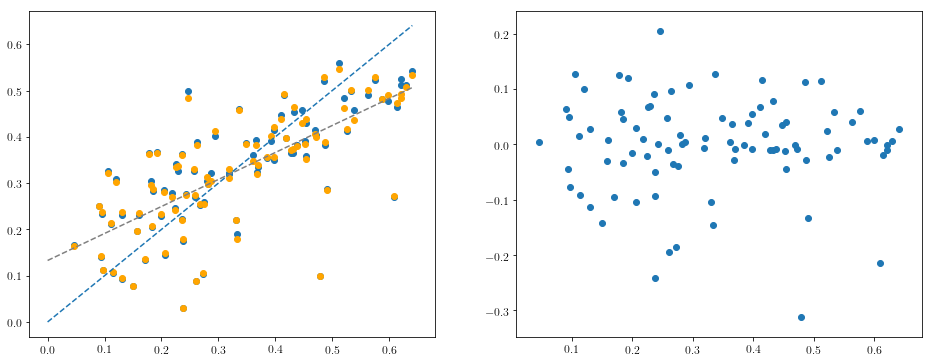

In [10]:
xi = np.linspace(0, Vmldavg.max())

fig, ax = plt.subplots(1, 2, figsize=(16,6))
ax[0].scatter(Vmldavg, Vgrad_ctd)
ax[0].scatter(Vmldavg, Vgeos_ctd, facecolors='orange')

ax[0].plot(xi, xi, linestyle='--')
ax[0].plot(xi, f(xi), linestyle='--', color='gray')

ax[1].scatter(Vmldavg, Vgeos_ctd-f(Vmldavg))

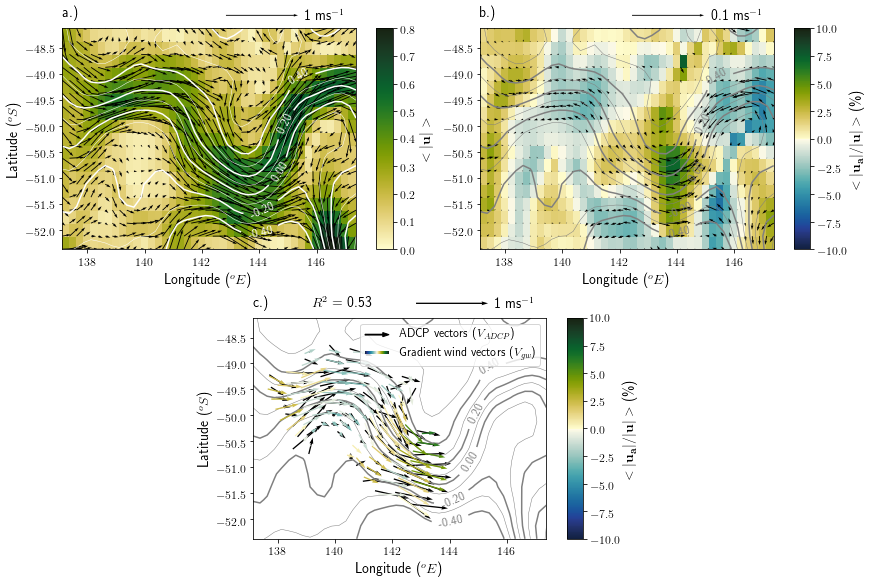

In [11]:
fig = plt.figure(figsize=(12, 8), constrained_layout=True)
gs = fig.add_gridspec(ncols=4, nrows=4)
# fig.tight_layout()

ax0 = fig.add_subplot(gs[:2, :2])
ax1 = fig.add_subplot(gs[:2, 2:])
ax2 = fig.add_subplot(gs[2:4, 1:3])
ax = fig.get_axes()

pcol = ax[0].pcolor(ssh.longitude, ssh.latitude, gw.Vgrad.sel(time=timevoy).mean('time'), 
                 vmin=0, vmax=0.8, cmap=cmo.cm.speed)
quiv = ax[0].quiver(ssh.longitude, ssh.latitude, gw.ugrad.mean('time'), gw.vgrad.mean('time'), 
                 units='inches', scale=1, width=1e-3*fig.get_size_inches()[0], color='k')
qk = plt.quiverkey(quiv, 0.34, 0.98, 1, r'1 ms$^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})
cbar = fig.colorbar(pcol, ax=ax[0])
cbar.ax.set_ylabel(r'$<|{\bf u}|>$', fontsize=fs_large)

cmap = cmo.cm.delta
vmin, vmax = -10, 10
pcol = ax[1].pcolor(ssh.longitude, ssh.latitude, dV_gw.sel(time=timevoy).mean('time'), 
                 vmin=vmin, vmax=vmax, cmap=cmap)
quiv = ax[1].quiver(ssh.longitude, ssh.latitude, uag.mean('time'), vag.mean('time'), 
                 units='inches', scale=0.1, width=1e-3*fig.get_size_inches()[0], color='k')
qk = plt.quiverkey(quiv, 0.81, 0.98, 0.1, r'0.1 ms$^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})
cbar = fig.colorbar(pcol, ax=ax[1])
cbar.ax.set_ylabel(r'$<|{\bf u_a}|/|{\bf u}|>$ (\%)', fontsize=fs_large)

# plot adcp velocity vectors
quiv2 = ax[2].quiver(lon_ctd[2:], lat_ctd[2:], umldmean[2:], vmldmean[2:], 
                  units='inches', scale=1, width=1.5e-3*fig.get_size_inches()[0], pivot='mid', zorder=2)
qk = plt.quiverkey(quiv2, 0.56, 0.48, 1, r'1 ms$^{-1}$', labelpos='E', coordinates='figure', 
                   fontproperties={'size': fs_large})
plt.text(0.2, 1.05, r'$R^2 = $ %s' %round(R2, 2), transform=ax2.transAxes, fontsize=fs_large)

# plot gradient velocity vectors with color indication for velocity difference with geostrophic
norm = mcolors.Normalize(vmin=vmin, vmax=vmax)

quiv3 = ax[2].quiver(lon_ctd[2:], lat_ctd[2:], gw_ctd['ugrad'][2:], gw_ctd['vgrad'][2:], color=cmap(norm(dV_ctd)),
                  units='inches', scale=1, width=1.5e-3*fig.get_size_inches()[0], pivot='mid', zorder=3)
# quiv3 = ax.quiver(lon_ctd, lat_ctd, np.mean(ugr, axis=0), np.mean(vgr, axis=0), color=cmap(norm(dV)),
#                   units='inches', scale=1, width=3e-3*fig.get_size_inches()[0], zorder=3)
# quiv2.set_label(r'ADCP vectors ($V_{ADCP}$)')
# quiv3.set_label(r'Gradient wind vectors ($V_{gw}$)')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm)
cbar.ax.set_ylabel(r'$<|{\bf u_a}|/|{\bf u}|>$ (\%)', fontsize=fs_large)
# ax[2].legend(loc=3)

def make_legend_arrow(legend, orig_handle, xdescent, ydescent, width, height, fontsize):
    p = FancyArrow(0, 0.5*height, width, 0, width=0.1*height, 
                            length_includes_head=True, head_width=0.5*height, color='k' )
    return p

labels = [r'ADCP vectors ($V_{ADCP}$)', r'Gradient wind vectors ($V_{gw}$)']
handles = [FancyArrow(0,0,0,0, facecolor='k'), 
           Rectangle((0, 0), 0, 0)] # Line2D([0], [0], color='k', lw=4)
handler_map = {
    FancyArrow: HandlerPatch(patch_func=make_legend_arrow),
    handles[1]: HandlerColormap(cmap, num_stripes=cmap.N)
}
ax[2].legend(handles=handles, labels=labels, handler_map=handler_map, fontsize=12)

# plot voyagemean ADT contours
ct_color = ['w', 'gray', 'gray']
bounds = [-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6]
manual = [(144, -52), (144, -51.5), (145, -51), (145, -50), (145, -48.6)]
for iax in range(len(ax)):
    ct = ax[iax].contour(ssh.longitude, ssh.latitude, ssh.adt.sel(time=timevoy).mean('time'), bounds, 
                         colors=ct_color[iax], linestyles='solid', linewidths=0.5)
    for ib, b in enumerate(bounds):
        if b in bounds[0::2]:
            zc = ct.collections[ib]
            plt.setp(zc, linewidth=1.5)
    ax[iax].clabel(ct, bounds[0::2], inline=1, fontsize=fs_small, fmt='%.2f', manual=manual)
    
    # plot labels
    ax[iax].text(0, 1.05, string.ascii_lowercase[iax] + '.)', transform=ax[iax].transAxes, size=fs_large, weight='bold')
    ax[iax].set_xlabel(r'Longitude ($^oE$)', fontsize=fs_large)
    if iax != 1:
        ax[iax].set_ylabel(r'Latitude ($^oS$)', fontsize=14)


In [12]:
if savefig:
    extensions = ['.png', '.pdf', '.eps']
    for extension in extensions:
        fig.savefig(os.path.join(figsdir, 'manuscripts', '01_manuscript', '06_surface-velocities' + extension), 
                    transparent=True)